In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import time
import scipy.stats as st
import os 
from lfimodels.balancednetwork.BalancedNetworkSimulator import BalancedNetwork
from lfimodels.balancednetwork.BalancedNetworkStats import BalancedNetworkStats
import delfi.distribution as dd

In [13]:
inference_method = 'basic'
filename = '15034110564604049_basic_ntrain20'

save_figure = True
path_to_save_folder = 'figures/'

time_str = filename[:filename.find('_')]
filename.find('_')
fullname = 'data/' + filename + '.p'

In [14]:
dim_params = 4
assert dim_params > 1, 'this notebook is for inference on more than 1 parameter.'
m = BalancedNetwork(dim=dim_params, first_port=8010, verbose=False, n_servers=3)

In [15]:
# load data 
with open(fullname, 'rb') as handle:
    result_dict = pickle.load(handle)

In [16]:
# unpack values 
true_params, stats_obs, nrounds, ntrain, posterior, out, trn_data = result_dict.values()

In [17]:
# extract the posterior 
n_components = len(posterior.a)
means = [posterior.xs[c].m for c in range(n_components)]
Ss = [posterior.xs[c].S for c in range(n_components)]

## Compare to true parameter 

We have generated the observed data ourselves so we do have the true parameter. The mean of the posterior should be close to it when evaluated for $x=x_{obs}$

In [19]:
def get_delfi_grid_pdf(theta, delfi_obj, log=False): 
    """
    Get pdf of a whole grid of values 
    """
    x, y = np.meshgrid(theta, theta)
    z = np.zeros_like(x)
    for i in range(z.shape[0]): 
        # arrange the samples in rows 
        v = np.array([x[i, :], y[i, :]]).T
        # evaluate the pdf for rows of z
        z[i, :] = delfi_obj.eval(x=v, log=log)
    return x, y, z

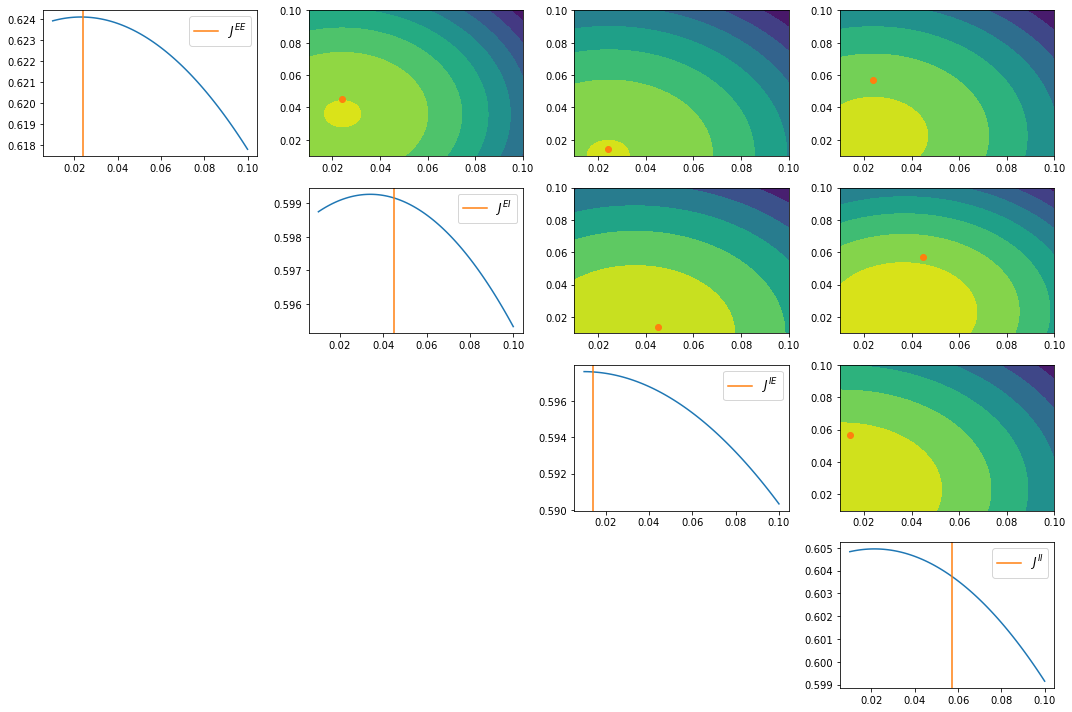

In [21]:
plt.figure(figsize=(15, 10))
theta = np.linspace(0.01, 0.1, 100)
weight_labels = ['$J^{EE}$', '$J^{EI}$', '$J^{IE}$', '$J^{II}$']
plot_idx = 1
for i in range(dim_params): 
    for j in range(dim_params): 
        if i==j: 
            
            # define a 1D MoG
            sub_means = [[means[c][i]] for c in range(n_components)]
            sub_cov = [[[Ss[c][i, j]]] for c in range(n_components)]
            pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)
            post_pdf = pdf.eval(theta[:, np.newaxis], log=False)
            
            plt.subplot(dim_params, dim_params, plot_idx)            
            plt.plot(theta, post_pdf)
            plt.axvline(x=true_params[0][i], color='C1', label=weight_labels[i])
            plt.legend(prop=dict(size=12))
            
        elif i < j:            
            # define a 2D MoG
            sub_means = [[posterior.xs[c].m[i], posterior.xs[c].m[j]] for c in range(n_components)]
            sub_cov = [[[posterior.xs[c].S[i, i], posterior.xs[c].S[i, j]], 
                       [posterior.xs[c].S[j, i], posterior.xs[c].S[j, j]]] for c in range(n_components)]
            pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)            
            x, y, z = get_delfi_grid_pdf(theta, delfi_obj=pdf, log=False)
        
            plt.subplot(dim_params, dim_params, plot_idx)
            plt.contourf(x, y, z)
            plt.plot([true_params[0][i]], [true_params[0][j]], 'o', color='C1')
        plot_idx += 1 

if save_figure and os.path.exists(path_to_save_folder): 
    filename = time_str + '_{}_posteriormatrix_r{}_ntrain{}.pdf'.format(inference_method, nrounds, ntrain)
    plt.tight_layout()
    plt.savefig('figures/' + filename)

## Posterior predictive checking: 

Sample from the estimated posterior and simulate with the sampled parameters.

In [ ]:
post = dd.mixture.MoG(posterior.a, means, Ss)

In [ ]:
# generate a few samples and simulate 
n_samples = 5 
params = []
for i in range(n_samples): 
    params.append(post.gen())

In [ ]:
params = np.array([post.a[c] * means[c] for c in range(n_components)]).sum(axis=0)
print(params)

In [ ]:
# setup a simulator 
m = BalancedNetwork(n_servers=1, dim=4, duration=3., first_port=8010, 
                   save_raster_plots=True, save_folder='/Users/Jan/Dropbox/Master/mackelab/code/lfi-experiments/balancednetwork/figures/simulation_raster_plots/')

In [ ]:
s = BalancedNetworkStats()

In [ ]:
try: 
    m.start_server()
except: 
    m.stop_server()
    print('server setup failed')

In [ ]:
# simulate 
data = m.gen(params)

In [ ]:
m.stop_server()

In [ ]:
# calculate summary stats
stats = []
for d in data: 
    stats.append(s.calc(d))

In [ ]:
stats = np.array(stats).squeeze()

In [ ]:
stats

In [ ]:
plt.plot(stats, 'o-', label='gen')
plt.plot(stats_obs.T, 'o-', label='obs')
plt.legend()